## やりたいこと
[2度目のグリッドサーチの結果](url:http://localhost:8888/notebooks/OneDrive/python/proto2020/開発日誌/AEscript.py‗20200426.ipynb)を受け、学習率を変動させた際のLossの傾向を検証する

In [1]:
#%%
# cording = UTF-8
import os,re,random,copy
import scipy,librosa
import numpy as np
import pandas as pd             #ほとんど使わんけど
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import sklearn

####################################初期化####################################
aug_amount = 100        #ファイルごとのAugmentationの回数
lr = 1e-04               #初期学習率
alpha = 1e-06           #L2正則化の係数
dr_rate = 0.2           #ドロップアウト率
batch_size = 50         #オフライン学習時のバッチサイズ
epochs = 100            #学習時のエポック数(グリッドサーチ時は無効)
monitor = "val_loss"    #学習率減衰/早期打ち切りの指標
encode_dim = 500        #オートエンコーダの圧縮次元
n_components = 0.999    #疑似AEの保持分散

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")
ok_dir = os.path.join(data_dir,"OK")
ng_dir = os.path.join(data_dir,"NG")
env_dir = os.path.join(data_dir,"environment")
log_dir = "./logs"       #Tensorboardログの保存パス
modeldir = "./models"   #学習済みモデルの保存パス

#学習用データファイル
datafile = "dataset2.npz"

####################################関数定義###################################

#対象ディレクトリのファイル一覧を取得
def get_file_list(dir):
    path = dir
    file_list = os.listdir(path)
    print("get file_list :{}".format(file_list))
    return file_list

#対象ディレクトリの最大ファイルをサーチ
def wav_search(dir,f_list):
    #呼び出されるごとに初期化する
    wave_list = []
    file_size = 0
    
    return_path = os.path.abspath('./')
    
    os.chdir(dir)
    for i in f_list:
        search_index = re.search('.wav',i)
        if search_index:
            wave_list .append(i)
            if os.path.getsize(i) > file_size:
                file_size = os.path.getsize(i)
                largest_file = i
        
    os.chdir(return_path)   #カレントディレクトリを戻す
    print("get file :{0} ,file size:{1}"\
        .format(largest_file,file_size))
    return wave_list,largest_file,file_size

#オーディオファイルの読み込み サンプルレート22.05kHz、モノラルで固定
def load_wav(dir,file):
    #呼び出されるごとに初期化する
    wf = np.arange(0)

    f_path = os.path.join(dir,file)
    wf,sp_rate = librosa.load(f_path,sr=22050,mono = True)
    del sp_rate
    return wf

#スペクトログラムの取得 パワースペクトラムのまま処理するならlibrosa不要
def get_spg(wf):
    spg = np.arange(0)
    sp_f,sp_t,spg = scipy.signal.spectrogram(wf,fs=22050,
        window = np.hamming(1024),nfft =1024)
#    spg = librosa.power_to_db(spg)
    spg =spg.astype('float16')
    return sp_f,sp_t,spg

#Augmentationの処理
def aug_process(frame,dir,wave_list,env_file,):
    #呼び出されるごとに初期化する
    length = 0
    count = 0
    wf = np.arange(0)

    length = int(frame * 1.2)
    for i in wave_list:
        wf = load_wav(dir,i)
        for j in range(aug_amount):
            start = random.randint(0,len(env_file)-length)
            aug_wav = copy.deepcopy(env_file[start : start + length])
            del start
            start = random.randint(0,len(aug_wav) - len(wf))
            aug_wav = aug_wav + random.gauss(1,0.05)
            aug_wav[ start:start + len(wf) ] = \
                aug_wav[ start : start + len(wf) ] + wf
            sp_f,sp_t,spg = get_spg(aug_wav)
            spg = spg.reshape(1,len(sp_f),len(sp_t))
            try:
                X_data
            except:
                X_data = copy.deepcopy(spg)
            else:
                X_data = np.vstack((X_data,spg))
            del start,aug_wav,sp_f,sp_t,spg
            count = count + 1
        del wf
        print("Augmentation done! total count = {}".format(count))

    return X_data

#データセットの作成 ここまでの関数は全部ここに集約される
#最大ファイルサイズに合わせてフレームサイズを定義し
#OK・NG各データセットを作成後、結合する

def new_dataset(aug,ok_dir,ng_dir,env_dir):
    #OKNGそれぞれのファイルリストと最大ファイルを取得
    ok_filelist = get_file_list(ok_dir)
    ok_wave_list,ok_largeest_name,ok_largest_size = wav_search(ok_dir,ok_filelist)
    ng_filelist = get_file_list(ng_dir)
    ng_wave_list,ng_largeest_name,ng_largest_size = wav_search(ng_dir,ng_filelist)

    #OKNGの最大を比較
    if ok_largest_size>ng_largest_size:
        largest_dir = ok_dir
        lergest_name = ok_largeest_name
        print("largetst:OK")
    else:
        largest_dir = ng_dir
        lergest_name = ng_largeest_name
        print("largetst:NG")

    #最大フレームサイズを取得
    wf = load_wav(largest_dir,lergest_name)
    frame = int(len(wf))
    #wf = np.insert(wf,frame,np.empty(int(frame*0.2))) #1.2倍する
    #sp_f,sp_t,spg = get_spg(wf) 
    #X_initsize = (len(sp_f),len(sp_t))
    #del wf,sp_f,sp_t,spg
    del wf

    #環境音データをロード
    env_data = load_wav(env_dir,"env.wav")
    
    #OKデータセット作成
    X_ok = copy.deepcopy(
        aug_process(frame,ok_dir,ok_wave_list,env_data)
        )
    y_ok = np.zeros(len(X_ok),dtype = 'bool')   #OKデータをfalse(陰性)と定義

    #NGデータセット作成
    X_ng = copy.deepcopy(
        aug_process(frame,ng_dir,ng_wave_list,env_data)
        )
    y_ng = np.ones(len(X_ng),dtype = 'bool')    #NGデータをTrue(陽性)と定義

    #データセットの結合
    X_data = np.vstack((X_ok,X_ng))
    y_data = np.append(y_ok,y_ng)
    del X_ok,y_ok,X_ng,y_ng

    return X_data,y_data

#OKNGが混在したデータからFalseのみを分離する
def mixed_to_sprit(X_mixed,y_mixed):
    #呼び出されるごとに初期化する
    try:
        X_sprit
    except:
        pass    #X_spritが存在しなければ何もしない
    else:
        del X_sprit #前のデータを消去する

    #y_mixedをboolianindexと見なし、論理値を反転してX_mixedから抽出
    X_sprit = X_mixed[np.logical_not(y_mixed)]

    return X_sprit

###################################メイン処理###################################

#データセット読み込み なければ作る
if os.path.exists(os.path.join(data_dir,datafile)) == False:
    X_data,y_data = new_dataset(aug_amount,ok_dir,ng_dir,env_dir)
    np.savez_compressed(os.path.join(data_dir,datafile),
        X = X_data,y = y_data)
    print("Data set saved!") #ファイルネーム表示機能つけること
else:
    load_data = np.load(os.path.join(data_dir,datafile))
    X_data =load_data['X']
    y_data = load_data['y']
    del load_data
    print("Data loaded!!")

X_shape = X_data.shape[1:]  #データの形状を取得


Data loaded!!


In [2]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = \
    train_test_split(
        X_data.reshape(len(X_data),-1), #アフィン変換
        y_data,
        test_size=0.05)
print(
"Training data amounts :{0}\n\
Test data amounts :{1}"\
.format(len(y_train),len(y_test))
)
del X_data,y_data

X_train_ae = mixed_to_sprit(X_train,y_train)
print(
"X_train for Autoencoder was splited!!\n\
amount/shape:{0}"
.format(X_train_ae.shape)
)

Training data amounts :3800
Test data amounts :200
X_train for Autoencoder was splited!!
amount/shape:(1894, 60021)


In [3]:
from keras.models import Model,Sequential
from keras.layers import Input, Dense,Dropout,Activation
from keras.layers.normalization import BatchNormalization
from keras import regularizers

#Functionalでの実装
def ae(input_dim,encode_dim,lr,alpha,dr_rate):

    input_data = Input(shape = (input_dim,))

    #エンコーダを定義
    encoder = Dense(
        encode_dim,
        kernel_initializer="he_normal",
        kernel_regularizer=regularizers.l2(alpha),
        )(input_data)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(dr_rate)(encoder)
    encoder = Activation("relu")(encoder)

    #デコーダを定義 こっちにはドロップアウトは定義しない
    decoder = Dense(input_dim,kernel_initializer="he_normal")(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation("sigmoid")(decoder)

    #モデルを定義
    autoencoder = Model(input = input_data,output = decoder)

    #最適化関数
    opt = keras.optimizers.Nadam(lr = lr)

    autoencoder.compile(
        optimizer = opt,loss='binary_crossentropy',metrics=['accuracy']
        )

    return autoencoder

#コールバック定義 早期打ち切り
def cb_es(monitor):
    x = keras.callbacks.EarlyStopping(monitor = monitor,patience=5)
    return x

Using TensorFlow backend.


In [4]:
cb_es = cb_es(monitor = monitor)

In [6]:
#lr = 1e-05
ae1 = ae(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = 1e-05,
    alpha = alpha,
    dr_rate = dr_rate
)

hist1 = ae1.fit(
    X_train_ae,X_train_ae,
    epochs = 20,
    batch_size = batch_size,
    callbacks = [cb_es],
    validation_split = 0.05,
    shuffle = True
)

print('Autoencoder learning is over!')

Train on 1799 samples, validate on 95 samples
Epoch 1/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.6940 - accuracy: 0.2519 - val_loss: 0.6938 - val_accuracy: 0.4171
Epoch 2/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.6938 - accuracy: 0.3735 - val_loss: 0.6936 - val_accuracy: 0.4171
Epoch 3/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.6936 - accuracy: 0.3937 - val_loss: 0.6936 - val_accuracy: 0.4171
Epoch 4/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.6935 - accuracy: 0.3991 - val_loss: 0.6935 - val_accuracy: 0.4171
Epoch 5/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.6930 - accuracy: 0.4005 - val_loss: 0.6927 - val_accuracy: 0.4171
Epoch 6/20
1799/1799 [==============================] - 59s 33ms/step - loss: 0.6927 - accuracy: 0.4006 - val_loss: 0.6926 - val_accuracy: 0.4171
Epoch 7/20
1799/1799 [==============================] - 59s 33ms/step - loss: 

In [7]:
#lr = 1e-06
ae2 = ae(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = 1e-06,
    alpha = alpha,
    dr_rate = dr_rate
)

hist2 = ae2.fit(
    X_train_ae,X_train_ae,
    epochs = 20,
    batch_size = batch_size,
    callbacks = [cb_es],
    validation_split = 0.05,
    shuffle = True
)

print('Autoencoder learning is over!')

Train on 1799 samples, validate on 95 samples
Epoch 1/20
1799/1799 [==============================] - 55s 31ms/step - loss: 0.6941 - accuracy: 0.2015 - val_loss: 0.6939 - val_accuracy: 0.4117
Epoch 2/20
1799/1799 [==============================] - 53s 30ms/step - loss: 0.6941 - accuracy: 0.2055 - val_loss: 0.6939 - val_accuracy: 0.4165
Epoch 3/20
1799/1799 [==============================] - 53s 29ms/step - loss: 0.6941 - accuracy: 0.2122 - val_loss: 0.6939 - val_accuracy: 0.4171
Epoch 4/20
1799/1799 [==============================] - 53s 29ms/step - loss: 0.6940 - accuracy: 0.2229 - val_loss: 0.6939 - val_accuracy: 0.4171
Epoch 5/20
1799/1799 [==============================] - 54s 30ms/step - loss: 0.6940 - accuracy: 0.2378 - val_loss: 0.6939 - val_accuracy: 0.4171
Epoch 6/20
1799/1799 [==============================] - 54s 30ms/step - loss: 0.6939 - accuracy: 0.2569 - val_loss: 0.6939 - val_accuracy: 0.4171
Epoch 7/20
1799/1799 [==============================] - 57s 32ms/step - loss: 

In [8]:
#lr = 1e-07
ae3 = ae(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = 1e-07,
    alpha = alpha,
    dr_rate = dr_rate
)

hist3 = ae3.fit(
    X_train_ae,X_train_ae,
    epochs = 20,
    batch_size = batch_size,
    callbacks = [cb_es],
    validation_split = 0.05,
    shuffle = True
)

print('Autoencoder learning is over!')

Train on 1799 samples, validate on 95 samples
Epoch 1/20
1799/1799 [==============================] - 56s 31ms/step - loss: 0.6941 - accuracy: 0.2004 - val_loss: 0.6939 - val_accuracy: 0.2396
Epoch 2/20
1799/1799 [==============================] - 55s 31ms/step - loss: 0.6941 - accuracy: 0.2006 - val_loss: 0.6939 - val_accuracy: 0.2406
Epoch 3/20
1799/1799 [==============================] - 56s 31ms/step - loss: 0.6941 - accuracy: 0.2008 - val_loss: 0.6939 - val_accuracy: 0.2411
Epoch 4/20
1799/1799 [==============================] - 55s 31ms/step - loss: 0.6941 - accuracy: 0.2011 - val_loss: 0.6939 - val_accuracy: 0.2411
Epoch 5/20
1799/1799 [==============================] - 55s 31ms/step - loss: 0.6941 - accuracy: 0.2014 - val_loss: 0.6939 - val_accuracy: 0.2408
Epoch 6/20
1799/1799 [==============================] - 55s 31ms/step - loss: 0.6941 - accuracy: 0.2017 - val_loss: 0.6939 - val_accuracy: 0.2405
Epoch 7/20
1799/1799 [==============================] - 56s 31ms/step - loss: 

In [9]:
#lr = 1e-08
ae4 = ae(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = 1e-08,
    alpha = alpha,
    dr_rate = dr_rate
)

hist4 = ae4.fit(
    X_train_ae,X_train_ae,
    epochs = 20,
    batch_size = batch_size,
    callbacks = [cb_es],
    validation_split = 0.05,
    shuffle = True
)

print('Autoencoder learning is over!')

Train on 1799 samples, validate on 95 samples
Epoch 1/20
1799/1799 [==============================] - 58s 32ms/step - loss: 0.6941 - accuracy: 0.2004 - val_loss: 0.6939 - val_accuracy: 0.2121
Epoch 2/20
1799/1799 [==============================] - 57s 32ms/step - loss: 0.6941 - accuracy: 0.2004 - val_loss: 0.6939 - val_accuracy: 0.2116
Epoch 3/20
1799/1799 [==============================] - 57s 32ms/step - loss: 0.6941 - accuracy: 0.2004 - val_loss: 0.6939 - val_accuracy: 0.2113
Epoch 4/20
1799/1799 [==============================] - 57s 32ms/step - loss: 0.6941 - accuracy: 0.2004 - val_loss: 0.6939 - val_accuracy: 0.2112
Epoch 5/20
1799/1799 [==============================] - 58s 32ms/step - loss: 0.6941 - accuracy: 0.2005 - val_loss: 0.6939 - val_accuracy: 0.2111
Epoch 6/20
1799/1799 [==============================] - 57s 32ms/step - loss: 0.6941 - accuracy: 0.2005 - val_loss: 0.6939 - val_accuracy: 0.2109
Epoch 7/20
1799/1799 [==============================] - 58s 32ms/step - loss: 

In [10]:
#lr = 1e-09
ae5 = ae(
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = 1e-09,
    alpha = alpha,
    dr_rate = dr_rate
)

hist5 = ae5.fit(
    X_train_ae,X_train_ae,
    epochs = 20,
    batch_size = batch_size,
    callbacks = [cb_es],
    validation_split = 0.05,
    shuffle = True
)

print('Autoencoder learning is over!')

Train on 1799 samples, validate on 95 samples
Epoch 1/20
1799/1799 [==============================] - 52s 29ms/step - loss: 0.6941 - accuracy: 0.2003 - val_loss: 0.6939 - val_accuracy: 0.2087
Epoch 2/20
1799/1799 [==============================] - 51s 28ms/step - loss: 0.6941 - accuracy: 0.2003 - val_loss: 0.6939 - val_accuracy: 0.2082
Epoch 3/20
1799/1799 [==============================] - 51s 28ms/step - loss: 0.6941 - accuracy: 0.2002 - val_loss: 0.6939 - val_accuracy: 0.2080
Epoch 4/20
1799/1799 [==============================] - 50s 28ms/step - loss: 0.6941 - accuracy: 0.2003 - val_loss: 0.6939 - val_accuracy: 0.2079
Epoch 5/20
1799/1799 [==============================] - 49s 27ms/step - loss: 0.6941 - accuracy: 0.2003 - val_loss: 0.6939 - val_accuracy: 0.2079
Epoch 6/20
1799/1799 [==============================] - 51s 28ms/step - loss: 0.6941 - accuracy: 0.2002 - val_loss: 0.6939 - val_accuracy: 0.2079
Epoch 7/20
1799/1799 [==============================] - 52s 29ms/step - loss: 

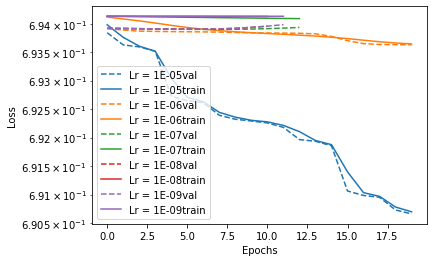

In [11]:
def plot_hist(histories,key = 'loss'):

    for name,history in histories:
        val = plt.plot(
            history.epoch,history.history['val_'+key],
            '--',label = name.title() + 'val'
            )
        plt.plot(history.epoch,history.history[key],color = val[0].get_color(),
        label = name.title() + 'train'
        )

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale("log")
    plt.legend()

plot_hist(
    [
        ('lr = 1e-05',hist1),
        ('lr = 1e-06',hist2),
        ('lr = 1e-07',hist3),
        ('lr = 1e-08',hist4),
        ('lr = 1e-09',hist5)
    ]
)    

## わかったこと
学習率1e-06以下だとほとんど学習が進まない(Lossが落ちない)
val_accuracyだけで判断するのは危険